In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Preprocess the images

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf

#### 1.1 Import the Image

In [ ]:
image = cv.imread('/content/drive/MyDrive/4th_Year/DSC4173/Project/Raw Images/Forest/2.jpg',1)

In [ ]:
print(f"Image Height : {image.shape[0]}")
print(f"Image Width : {image.shape[1]}")

Image Height : 350
Image Width : 350


#### 1.2 Reshape The Image to 256 x 256

New Image Height : 256
New Image Width : 256


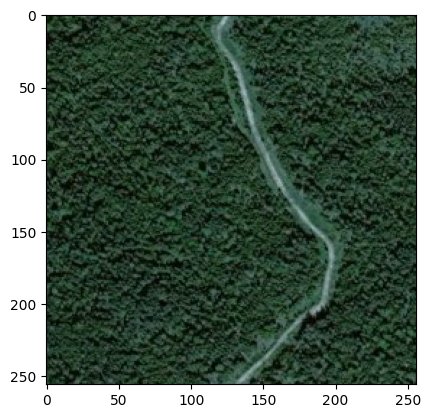

In [ ]:
patch_size = 256

image_height = (image.shape[0]//patch_size)*patch_size
image_width = (image.shape[1]//patch_size)*patch_size

image = Image.fromarray(image) # convert nd.array image to PIL.Image for crop the image

image = image.crop((0, 0, image_width, image_height)) # crop the image
image = np.array(image)

print(f"New Image Height : {image.shape[0]}")
print(f"New Image Width : {image.shape[1]}")

plt.imshow(image) #Original BGR image

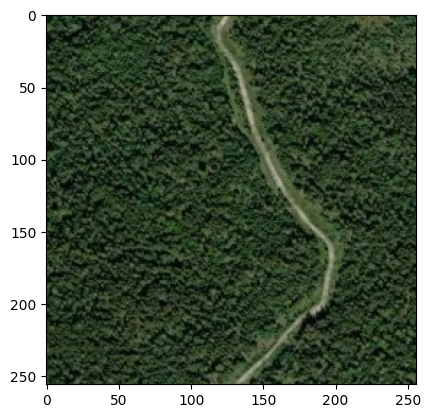

In [ ]:
rgb_image = cv.cvtColor(image, cv.COLOR_BGR2RGB) # color converting -> BGR format to RGB format
plt.imshow(rgb_image) # Original RGB image

#### 1.3 Create a Mask for a Image

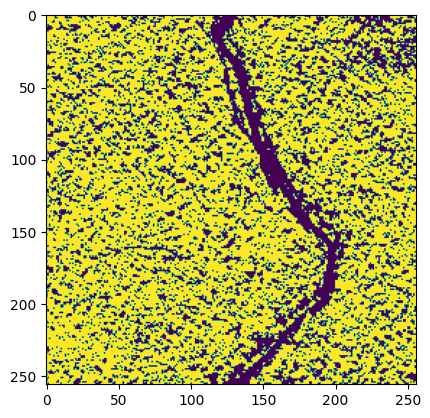

In [ ]:
lower_green = np.array([0, 10, 0], dtype = "uint8")
upper_green = np.array([175, 255, 50], dtype = "uint8")

mask_image = cv.inRange(rgb_image, lower_green, upper_green)

plt.imshow(mask_image)

#### 1.4 Save the Mask Image

In [ ]:
# plt.imsave("/content/drive/MyDrive/4th_Year/DSC4173/Project/Mask/Forest/1.jpg", mask_image)

# 2. Perform on Image Segmentation

#### 2.1 Prepare the data set for train U_Net Model

In [ ]:
images = []
mask_images = []

for i in range(1,51):
  image = cv.imread(f'/content/drive/MyDrive/4th_Year/DSC4173/Project/Images/Forest/{i}.jpg',1)
  image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
  images.append(image)

for i in range(1,51):
  mask = cv.imread(f'/content/drive/MyDrive/4th_Year/DSC4173/Project/Mask/Forest/{i}.jpg',1)
  mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
  mask_images.append(mask)

for i in range(51,101):
  image = cv.imread(f'/content/drive/MyDrive/4th_Year/DSC4173/Project/Images/Deforest/{i}.jpg',1)
  image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
  images.append(image)

for i in range(51,101):
  mask = cv.imread(f'/content/drive/MyDrive/4th_Year/DSC4173/Project/Mask/Deforest/{i}.jpg',1)
  mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
  mask_images.append(mask)

#### 2.2 Visualize the Data set

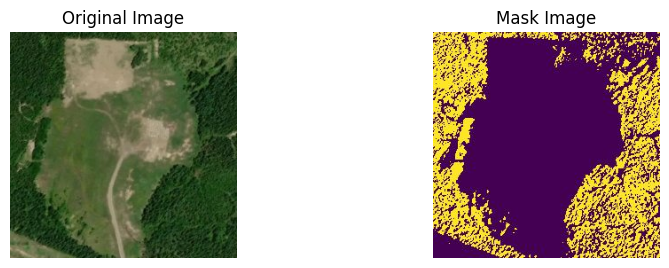

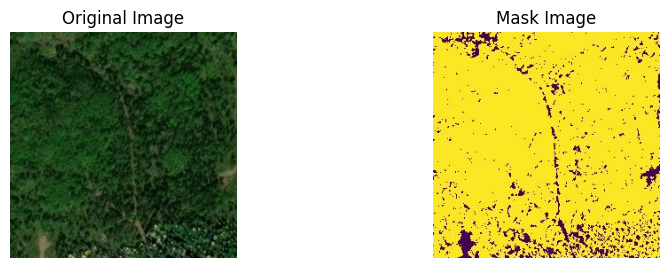

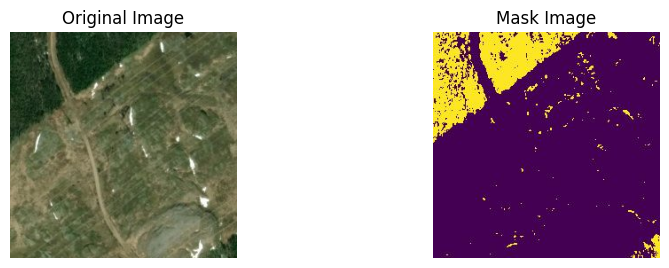

In [ ]:
import random

for i in range(1,4):
  image_number = random.randint(0, len(images)-2)
  plt.figure(figsize=(10, 10))

  plt.subplot(3,2,i*2-1)
  plt.imshow(images[image_number])
  plt.title("Original Image")
  plt.axis('off')

  plt.subplot(3,2,i*2)
  plt.imshow(mask_images[image_number], cmap='gray')
  plt.title("Mask Image")
  plt.axis('off')

#### 2.3 Split the data set as a training and testing

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, mask_images, test_size = 0.25, random_state = 0)

#### 2.4 Normalize Image RGB Values

In [ ]:
X_train_norm, X_test_norm = np.array(X_train)/255, np.array(X_test)/255
y_train_norm, y_test_norm = np.array(y_train)/255, np.array(y_test)/255

#### 2.5 Sanity check

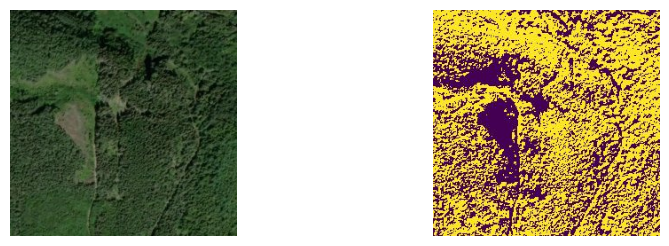

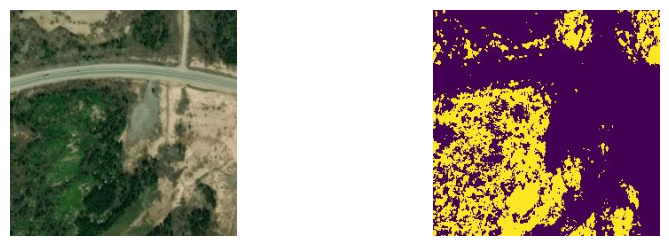

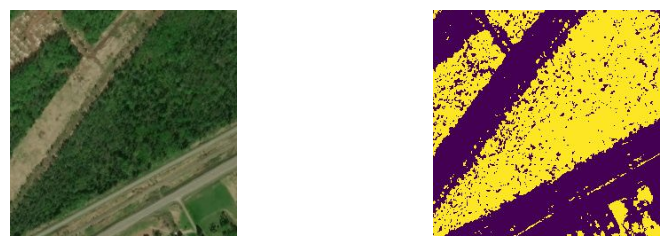

In [ ]:
import numpy as np

for i in range(1,4):
  image_number = random.randint(0, len(X_train))
  plt.figure(figsize=(10, 10))
  plt.subplot(3,2,i*2-1)
  plt.axis('off')
  plt.imshow(X_train[image_number], cmap='gray')
  plt.subplot(3,2,i*2)
  plt.imshow(y_train[image_number], cmap='gray')
  plt.axis('off')

#### 2.6 Create a U_Net Model

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam


def encoder_block(input, num_filters, dropout_val):
  x = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input)
  x = Dropout(dropout_val)(x)
  x = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
  p = MaxPooling2D((2, 2))(x)

  return x, p


def conv_block(input, num_filters, dropout_val):
  x = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input)
  x = Dropout(dropout_val)(x)
  x = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)

  return x


def decoder_block(input, skip_features, num_filters, dropout_val):
  x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(input)
  x = concatenate([x, skip_features])
  x = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
  x = Dropout(dropout_val)(x)
  x = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)

  return x


def build_Unet(img_height, img_width, img_channels):
  input = Input((img_height, img_width, img_channels))

  x1, p1 = encoder_block(input, 16, 0.1)
  x2, p2 = encoder_block(p1, 32, 0.1)
  x3, p3 = encoder_block(p2, 64, 0.2)
  x4, p4 = encoder_block(p3, 128, 0.2)

  b = conv_block(p4, 256, 0.3)

  d1 = decoder_block(b, x4, 128, 0.2)
  d2 = decoder_block(d1, x3, 64, 0.2)
  d3 = decoder_block(d2, x2, 34, 0.1)
  d4 = decoder_block(d3, x1, 64, 0.1)

  output = Conv2D(3, (1, 1), padding="same", activation='sigmoid')(d4)
  model = Model(inputs=[input], outputs=[output], name="U-Net")

  return model

#### 2.7 Compile the U_Net Model

In [ ]:
model = build_Unet(256,256,3)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

#### 2.8 Fit the U_Net Model

In [ ]:
history = model.fit(X_train_norm, y_train_norm, batch_size = 32, epochs=50, validation_data=(X_test_norm, y_test_norm), shuffle=True)

Epoch 1/50
3/3 [==============================] - 218s 65s/step - loss: 0.4661 - accuracy: 0.8760 - val_loss: 0.4572 - val_accuracy: 0.9303
Epoch 2/50
3/3 [==============================] - 202s 61s/step - loss: 0.4740 - accuracy: 0.9042 - val_loss: 0.4584 - val_accuracy: 0.9323
Epoch 3/50
3/3 [==============================] - 204s 64s/step - loss: 0.4684 - accuracy: 0.8882 - val_loss: 0.4594 - val_accuracy: 0.9217
Epoch 4/50
3/3 [==============================] - 206s 64s/step - loss: 0.4614 - accuracy: 0.8920 - val_loss: 0.4673 - val_accuracy: 0.9332
Epoch 5/50
3/3 [==============================] - 214s 63s/step - loss: 0.4629 - accuracy: 0.8875 - val_loss: 0.4623 - val_accuracy: 0.9001
Epoch 6/50
3/3 [==============================] - 205s 64s/step - loss: 0.4718 - accuracy: 0.8513 - val_loss: 0.4569 - val_accuracy: 0.9215
Epoch 7/50
3/3 [==============================] - 206s 64s/step - loss: 0.4694 - accuracy: 0.8881 - val_loss: 0.4640 - val_accuracy: 0.9342
Epoch 8/50
3/3 [====

#### 2.9 Acccuracy of the U_Net Model

In [ ]:
_, acc = model.evaluate(X_test_norm, y_test_norm)

print("U_Net Model Accuracy : ", round((acc * 100.0),2), "%")

1/1 [==============================] - 15s 15s/step - loss: 0.4483 - accuracy: 0.9276
U_Net Model Accuracy :  92.76 %


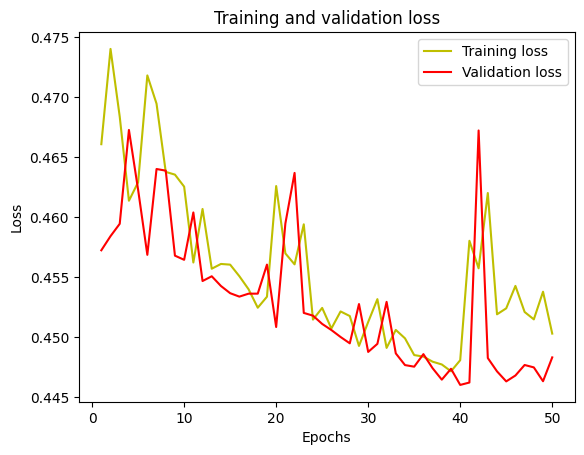

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

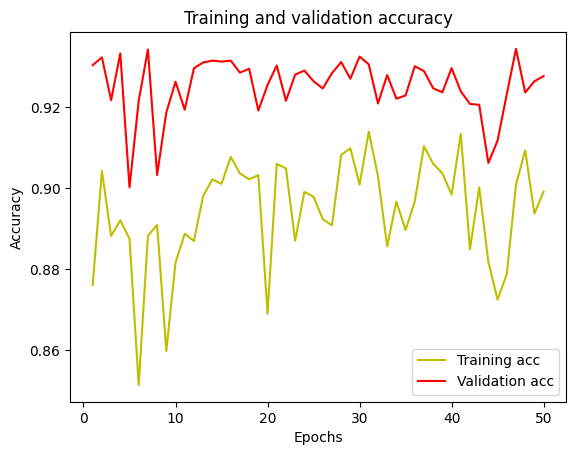

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#IOU
y_pred=model.predict(X_test_norm)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test_norm, y_pred_thresholded)
union = np.logical_or(y_test_norm, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)

print("IoU socre is: ", round(iou_score,2))

1/1 [==============================] - 16s 16s/step
IoU socre is:  0.45


#### 2.10 Testing the U_Net Model

1/1 [==============================] - 1s 1s/step


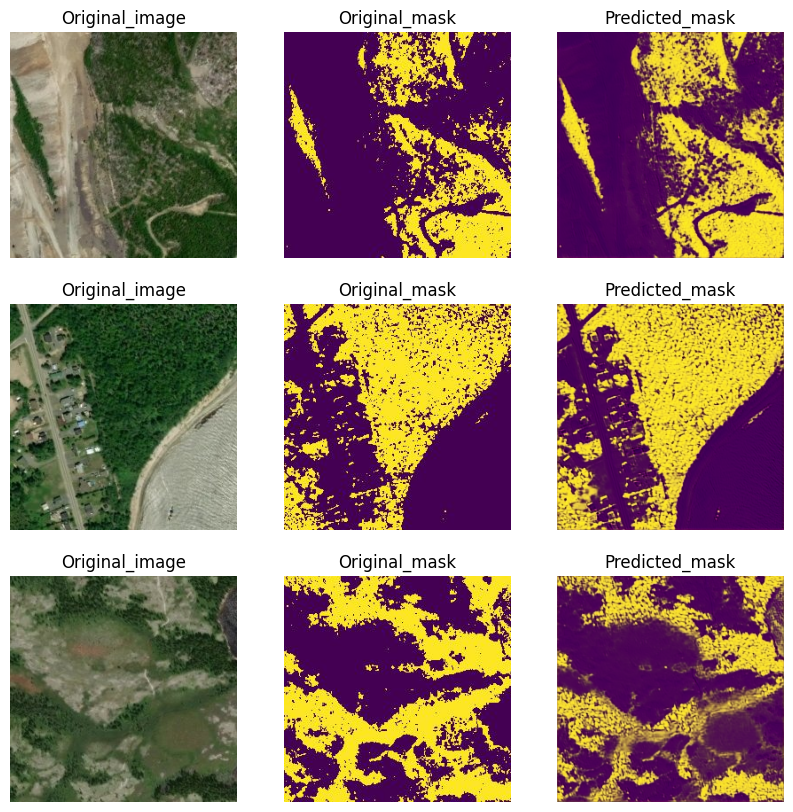

In [ ]:
# image_number = random.randint(0, len(X_test))
plt.figure(figsize=(10, 10))
for i in range(1,4):
  image_number = random.randint(0, len(X_test))
  original_image = X_test[image_number]
  original_mask = y_test[image_number]
  test_img_input=np.expand_dims(X_test_norm[image_number], 0)
  predicted_mask = model.predict(test_img_input)

  ax = plt.subplot(3, 3, i*3-2)
  plt.imshow(original_image)
  plt.title("Original_image")
  plt.axis("off")

  ax = plt.subplot(3, 3, i*3-1)
  plt.imshow(original_mask)
  plt.title("Original_mask")
  plt.axis("off")

  ax = plt.subplot(3, 3, i*3)
  plt.imshow(predicted_mask[0])
  plt.title("Predicted_mask")
  plt.axis("off")

#### 2.11 Save U_Net the Model

In [ ]:
model.save('/content/drive/MyDrive/4th_Year/DSC4173/Project/Unet_epoch_501')

# 3. Perform on Image Classification

#### 3.1 Prepare the dataset train ResNet Model

In [ ]:
images = []
labels = []

for i in range(1,51):
  mask = cv.imread(f'/content/drive/MyDrive/4th_Year/DSC4173/Project/Mask/Forest/{i}.jpg',1)
  mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
  labels.append(0)
  images.append(mask)

for i in range(51,101):
  mask = cv.imread(f'/content/drive/MyDrive/4th_Year/DSC4173/Project/Mask/Deforest/{i}.jpg',1)
  mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
  labels.append(1)
  images.append(mask)

images = np.array(images)

labels = np.array(labels)

#### 3.2 Visualize the Data set

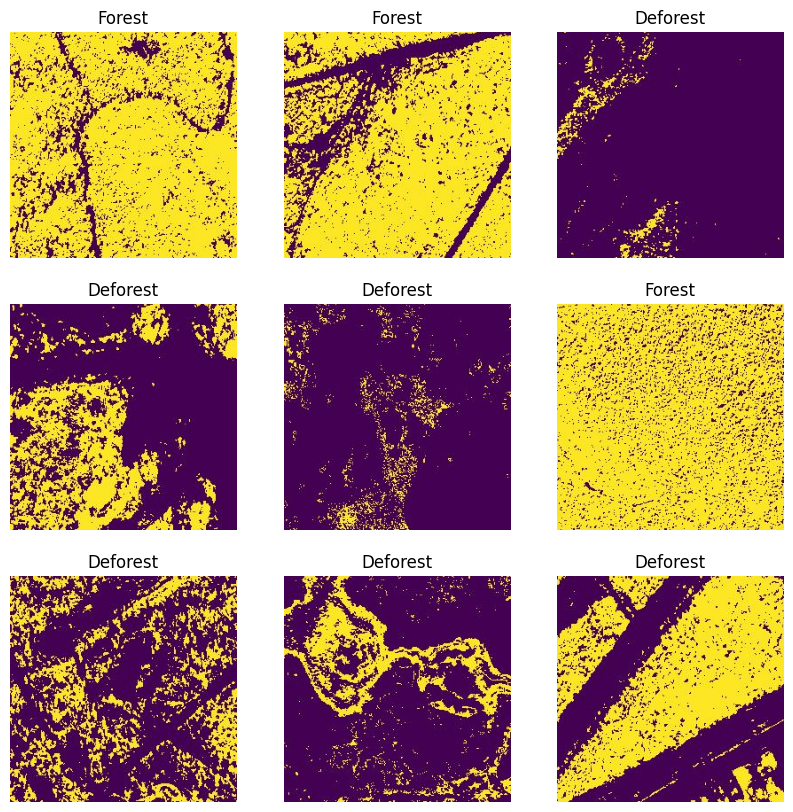

In [ ]:
plt.figure(figsize=(10, 10))

for i in range(1,10):
  image_number = random.randint(0, len(images))
  ax = plt.subplot(3, 3, i)
  plt.imshow(images[image_number])
  if labels[image_number] == 0:
    plt.title('Forest')
  else:
    plt.title('Deforest')
  plt.axis("off")

#### 3.3 Split the data set as a training and testing

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.25, random_state = 0)

X_train_norm, X_test_norm = X_train/255, X_test/255

#### 3.4 Build The ResNet Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.initializers import glorot_uniform


def conv_layer(model, num_filters, dropout):

  model.add(Conv2D(num_filters, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(dropout))

  return model


def hidden_layer(model, num_filters, dropout):

  model.add(Dense(num_filters, activation='relu'))
  model.add(Dropout(dropout))

  return model


def build_CNN(input):
  # building a linear stack of layers with the sequential model
  model = Sequential()

  model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=input))
  model = conv_layer(model, 64, 0.1)
  model = conv_layer(model, 128, 0.2)
  model = conv_layer(model, 256, 0.3)

  model.add(Flatten())

  model = hidden_layer(model, 256, 0.3)
  model = hidden_layer(model, 128, 0.2)
  model = hidden_layer(model, 64, 0.1)
  model.add(Dense(1, activation='sigmoid', kernel_initializer = glorot_uniform(seed=0)))

  return model

#### 3.5 Compile the ResNet Model

In [ ]:
model = build_CNN((256, 256, 3))
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                    

#### 3.6 Fit the ResNet Model

In [ ]:
history = model.fit(X_train_norm, y_train, batch_size=32, epochs=50, validation_data=(X_test_norm, y_test))

Epoch 1/50
3/3 [==============================] - 76s 20s/step - loss: 3.2742 - accuracy: 0.4667 - val_loss: 0.7502 - val_accuracy: 0.4800
Epoch 2/50
3/3 [==============================] - 62s 18s/step - loss: 0.7471 - accuracy: 0.5867 - val_loss: 0.6918 - val_accuracy: 0.4800
Epoch 3/50
3/3 [==============================] - 61s 18s/step - loss: 0.7006 - accuracy: 0.4933 - val_loss: 0.6833 - val_accuracy: 0.5200
Epoch 4/50
3/3 [==============================] - 69s 21s/step - loss: 0.6652 - accuracy: 0.6400 - val_loss: 0.6505 - val_accuracy: 0.5200
Epoch 5/50
3/3 [==============================] - 61s 19s/step - loss: 0.6148 - accuracy: 0.6267 - val_loss: 0.4646 - val_accuracy: 0.9200
Epoch 6/50
3/3 [==============================] - 63s 20s/step - loss: 0.4575 - accuracy: 0.8133 - val_loss: 1.2162 - val_accuracy: 0.5200
Epoch 7/50
3/3 [==============================] - 61s 18s/step - loss: 0.8821 - accuracy: 0.6800 - val_loss: 0.3939 - val_accuracy: 0.7600
Epoch 8/50
3/3 [===========

#### 3.7 Accuracy of the ResNet Model

In [ ]:
_, acc = model.evaluate(X_test_norm, y_test)

print("ResNet Model Accuracy : ", round((acc * 100.0),2), "%")

1/1 [==============================] - 6s 6s/step - loss: 1.8266 - accuracy: 0.9200
ResNet Model Accuracy :  92.0 %


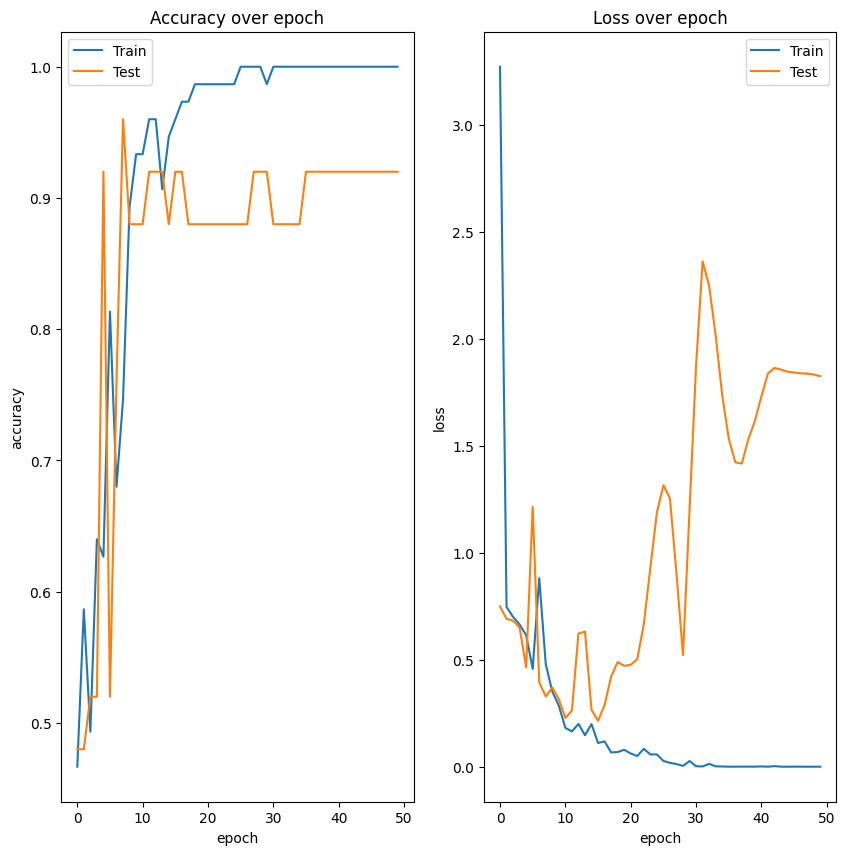

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy over epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Loss over epoch')
ax2.legend(['Train', 'Test'], loc="upper right")

#### 3.8 Test the ResNet Model

1/1 [==============================] - 0s 326ms/step


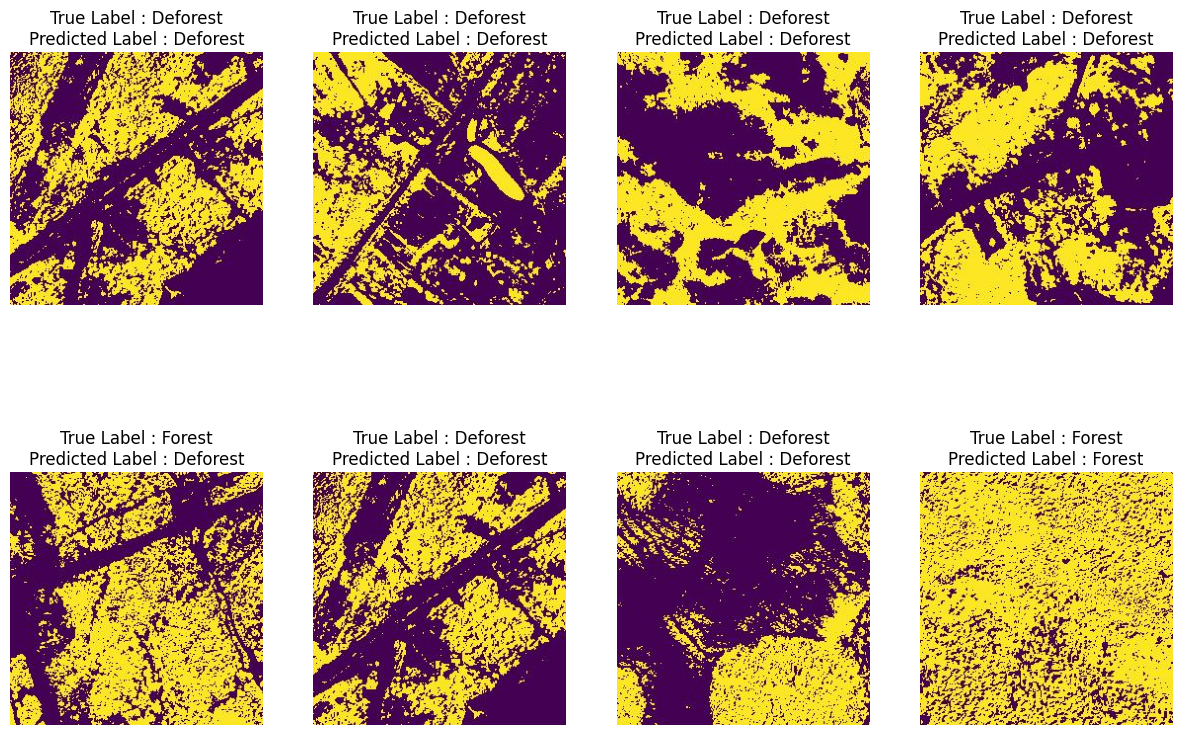

In [ ]:
import random

plt.figure(figsize=(15, 10))

for i in range(1,9):
  image_number = random.randint(0, len(X_test)-2)
  img = X_test[image_number]


  true_label = y_test[image_number]
  if true_label == 0:
    true_label = 'Forest'
  else:
    true_label = 'Deforest'


  input_img = np.expand_dims(X_test_norm[image_number], 0)
  predict_label = model.predict(input_img)[0][0]
  if predict_label >= 0.5:
    predict_label = 'Deforest'
  else:
    predict_label = 'Forest'

  ax=plt.subplot(2, 4, i)
  plt.imshow(img)
  plt.title(f"True Label : {true_label}\nPredicted Label : {predict_label}")
  plt.axis("off")

#### 3.9 Confusion Matrix

In [ ]:
true_labels = y_test
predict_labels = []

for i in range(len(X_test_norm)):
  input_img = np.expand_dims(X_test_norm[i], 0)
  predict_label = model.predict(input_img)[0][0]
  if predict_label >= 0.5:
    predict_labels.append(1)
  else:
    predict_labels.append(0)

predict_labels = np.array(predict_labels)

1/1 [==============================] - 0s 195ms/step


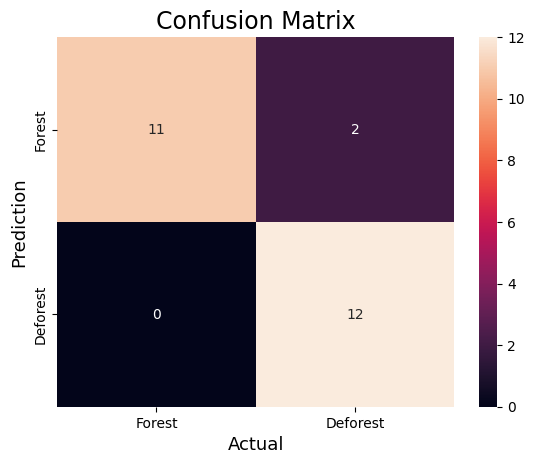

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels,predict_labels)

sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Forest','Deforest'],
            yticklabels=['Forest','Deforest'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

#### 3.10 Save the ResNet Model

In [ ]:
model.save('/content/drive/MyDrive/4th_Year/DSC4173/Project/ResNet_epoch_50')

# 4. Make Predictions of Our Data set Using U_Net + ResNet Models

#### 4.1 Load the Models

In [ ]:
from keras.models import load_model

unet_model = load_model('/content/drive/MyDrive/4th_Year/DSC4173/Project/Unet_epoch_50')
cnn_model = load_model('/content/drive/MyDrive/4th_Year/DSC4173/Project/ResNet_epoch_50')

In [ ]:
!pip install patchify
from patchify import patchify
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

#### 4.2 Import new Unlabeled satellite image

In [ ]:
image = cv.imread('/content/drive/MyDrive/Colab Notebooks/images/6.jpg', 1)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
patches = patchify(image, (256,256,3), step = 256) # divide image in to patches
print(patches.shape)

(8, 15, 1, 256, 256, 3)


#### 4.3 Create a Mask image using U_Net Model

In [ ]:
rows = patches.shape[0]
cols = patches.shape[1]

all_masks = []
for row in range(rows):
  for col in range(cols):
    input = np.expand_dims((patches[row][col][0])/255, 0)
    predicted_mask = unet_model.predict(input)
    all_masks.append(predicted_mask)

1/1 [==============================] - 1s 560ms/step


#### 4.4 Predict the label of the image using ResNet Model

In [ ]:
labels = []

for input in all_masks:
  predict_label = cnn_model.predict(input)[0][0]
  labels.append(predict_label)

label = sum(labels)/len(labels)

predict_label = ''
if label >= 0.5:
    predict_label = 'Deforest'
else:
  predict_label = 'Forest'

1/1 [==============================] - 0s 348ms/step


#### 4.5 Merge the patchify mask image

In [ ]:
mask_image = np.zeros((256*rows,256*cols,3))

image_count = 0
for row in range(rows):
  for col in range(cols):
    for channel in range(3):
      mask_image[row*256:(row+1)*256, col*256:(col+1)*256, channel] = all_masks[image_count][0][:,:,channel]*255
    image_count += 1

mask_image = mask_image.astype('int')

#### 4.6 Plot the Original image, Mask image and the it's predicted label

(-0.5, 3839.5, 2047.5, -0.5)

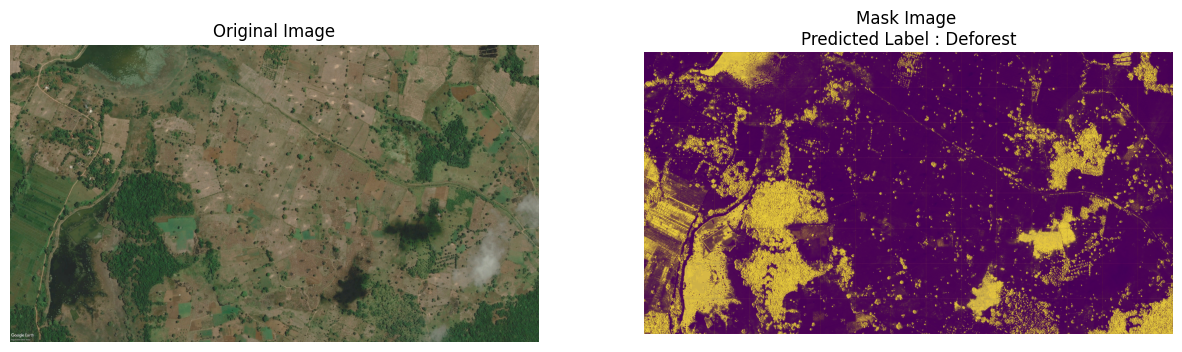

In [ ]:
plt.figure(figsize=(15, 15))

ax=plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

ax=plt.subplot(1, 2, 2)
plt.imshow(mask_image)
plt.title(f"Mask Image \nPredicted Label : {predict_label}")
plt.axis("off")